# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 19: Generalized Linear Models IV. Poisson Regression. Zero-Inflated Poisson Regression. Negative Binomial Regression. 

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - parameters
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()

# - rng
rng = np.random.default_rng(1234)

# - plots
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set_theme(style='white')

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

## 1. Poisson Regression

Poisson regression is a statistical modeling technique used to analyze data that follows a Poisson distribution. The Poisson distribution is commonly used to model count data, where the number of occurrences of an event is of interest. Poisson regression extends this concept by allowing the analysis of multiple predictors or independent variables to explain the count response variable.

In Poisson regression, the dependent variable is assumed to follow a Poisson distribution, which means it represents counts of events occurring within a fixed interval of time or space. The independent variables are typically continuous, categorical, or a combination of both. The goal is to estimate the relationship between the independent variables and the expected count of events.

The key assumption in Poisson regression is that the mean and variance of the dependent variable are equal. This assumption is known as equidispersion. However, count data often exhibit overdispersion, where the variance exceeds the mean. In such cases, the Negative Binomial regression, which accounts for overdispersion, may be more appropriate.

Poisson regression uses the log-link function to model the relationship between the predictors and the expected count. The log transformation ensures that the predicted counts are positive. The model estimates coefficients for each independent variable, indicating how they contribute to the expected count. These coefficients can be interpreted as the change in the log count for a one-unit change in the corresponding predictor, assuming all other variables are held constant.

Poisson regression is used in various fields where count data analysis is relevant, such as:

- Epidemiology: Analyzing disease incidence or event counts.
- Finance: Modeling the frequency of rare events like defaults or insurance claims.
- Social sciences: Examining the number of criminal offenses or the frequency of certain behaviors.
- Marketing: Analyzing the number of customer purchases or website visits.
- Ecology: Studying population counts or species abundance.

### Refresher: Poisson Distribution

Poisson Distribution gives an answer to the following question: *if the average number of occurences of an event during some time interval is $\lambda$ - what is the probability of that event occuring $k$ times during the that interval?* 

Poisson Distribution has only one parameter: average number of occurences $\lambda$.

Random variable $X$ having Poisson Distribution has (countably) infinite values.

We can calculate probabilities theoretically using a formula for a RV having Geometric Distribution:

$$P(X=k) = \frac{\lambda^ke^{-\lambda}}{k!}.$$

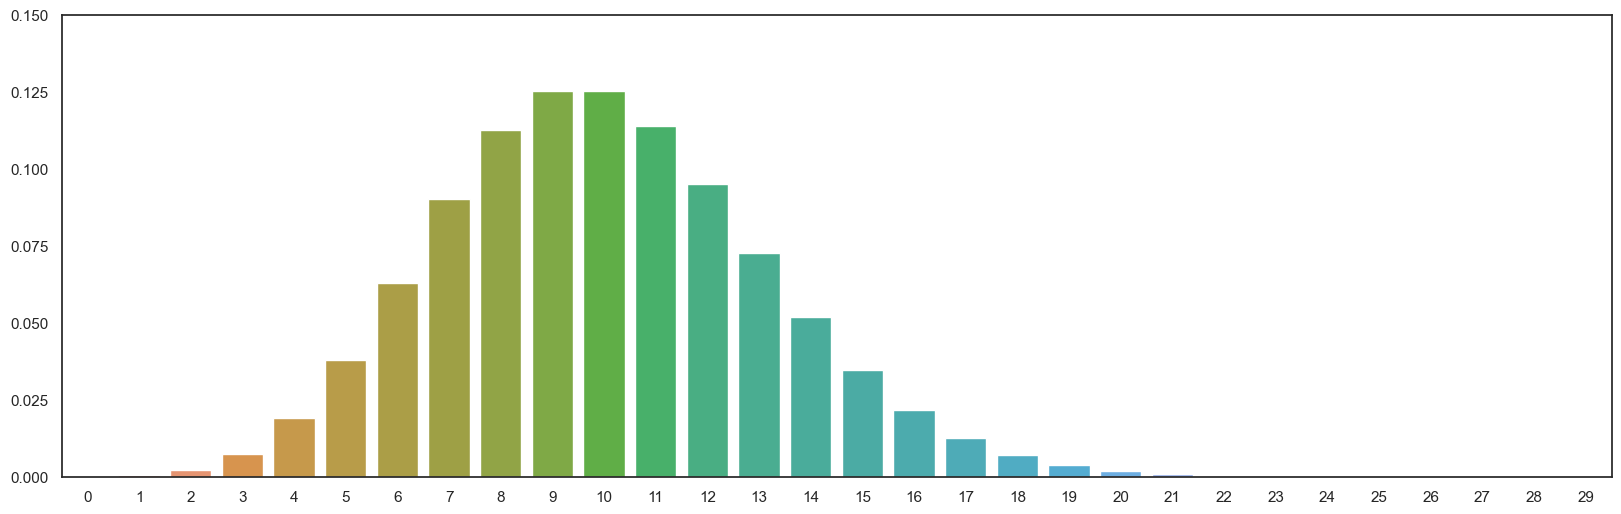

In [2]:
def sample_from_poisson(lam, no_tries=10**6, k=None):
    
    outcomes = rng.poisson(lam, size=no_tries)
    no_outcomes = np.unique(outcomes, return_counts=True)


    fig, ax = plt.subplots(figsize=(20, 6))

    sns.barplot(ax = ax, x = no_outcomes[0], y = no_outcomes[1]/no_tries)
    
    
    if k:
        p_theor = lam**k*np.exp(-lam)/np.math.factorial(k)
        ax.axhline(p_theor, c='m', linestyle='--')


    ax.set_yticks(np.arange(0, np.max(no_outcomes[1]/no_tries) + .025, .025)); 

sample_from_poisson(lam=10, no_tries=10**6)

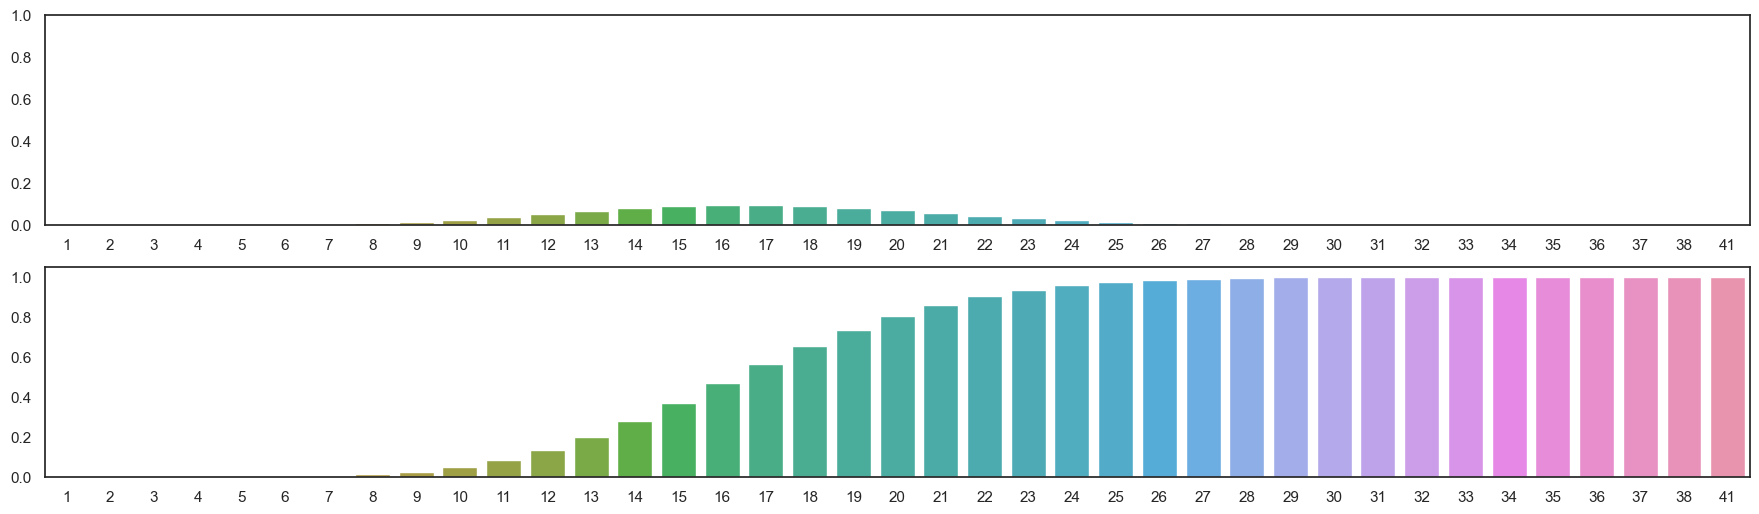

In [3]:
def cdf_poisson(lam):
    outcomes = rng.poisson(lam, size=10**6)
    no_outcomes = np.unique(outcomes, return_counts=True)


    fig, ax = plt.subplots(2, 1, figsize=(22, 6))

    sns.barplot(ax = ax[0], x = no_outcomes[0], y = no_outcomes[1]/10**6)
    sns.barplot(ax = ax[1], x = no_outcomes[0], y = np.cumsum(no_outcomes[1]/10**6))

    ax[0].set_yticks(np.arange(0, 1.2, .2));     
    ax[1].set_yticks(np.arange(0, 1.2, .2)); 

cdf_poisson(lam=17)

### Poisson Regression: simple model derivation

As in all GLMs in general, the problem to be solved is how to apply the Linear Model in a situation where our data fail to satisfy its assumptions. The *Poisson regression* deals with the situation where our observations - the outcome variable - are *counts per some unit of time or space*. 

To introduce the crucial model assumption precisely before we derive the model, Poisson regression assumes the response variable $Y$ has a Poisson distribution, and assumes the *logarithm of its expected value* can be modeled by a linear combination of (a) predictors and (b) coefficients (that need to be estimated, of course). More precisely, the Poisson regression models $\lambda_i$, the average number of occurrences of a phenomenon, as a function of one or more predictors. For example, we could consider the average number of car accidents in some state **S** in year **Y** as a function of a specific set of regulations that were in force in that state in that year. Let's take a closer look at the model:

$$log(\lambda_i) = \beta_0 + \beta_1x_i$$

or more generally

$$log(\lambda) = \beta_0 + \beta_1X$$

while assuming that where the observed values $Y_i$ follow a Poisson distribution with $\lambda = \lambda_i$ for a given $x_i$. For each observation then we could have a different value of $\lambda$ depending on a particular value of the predictor $X$. The model is easily expanded to encompass more predictors:

$$log(\lambda) = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n$$

The model assumptions are:

- **Poisson outcome:** the outcome is a count per unit of time or space and follows a Poisson distribution;
- **independence:** all observations are independent of one another; 
- **the mean is equal to the variance:** simply, because by definition we know that the mean of a Poisson variable must be equal to its variance; and
- **Linearity:** as in all linear models, of course, and specifically here the log of the mean rate $log(\lambda)$ must be a linear combination of $X$.

Let's start with the equation:

$$
\log(\lambda) = \beta_0 + \beta_1X
$$

where $X$ represents the independent variable, $\lambda$ represents the expected count of events (also known as the rate parameter) for a given value of $X$, and $\beta_0$ and $\beta_1$ are the coefficients to be estimated, and immediately it follows that

$$
\lambda = e^{\beta_0 + \beta_1X}
$$

In Poisson Regression, we assume that the dependent variable, denoted as $Y$, follows a Poisson distribution with parameter $\lambda$. The Poisson distribution describes the probability of observing a given number of events within a fixed interval.

For each observation, we have a value of $X$ and a corresponding observed count of events $Y$. Our goal is to estimate the coefficients $\beta_0$ and $\beta_1$ that best fit the observed data.

The Poisson probability mass function (PMF) is given by:

$$
P(Y=y) = \frac{e^{-\lambda}\lambda^y}{y!}
$$

We can rewrite this equation using the equation $\lambda = e^{\beta_0 + \beta_1X}$:

$$
P(Y=y) = \frac{e^{-(e^{\beta_0 + \beta_1X})}(e^{\beta_0 + \beta_1X})^y}{y!}
$$

To estimate the coefficients $\beta_0$ and $\beta_1$, we use the method of maximum likelihood estimation (MLE). The likelihood function is defined as the joint probability of observing the given set of $Y$ values given the corresponding $X$ values and the model:

$$
L(\beta_0, \beta_1) = \prod_{i=1}^n P(Y=y_i)
$$

To simplify calculations, it is common to work with the log-likelihood function:

$$
\ell(\beta_0, \beta_1) = \log L(\beta_0, \beta_1) = \sum_{i=1}^n \log P(Y=y_i)
$$

Substituting the Poisson PMF into the log-likelihood function, we get:

$$
\ell(\beta_0, \beta_1) = \sum_{i=1}^n \left[-e^{(e^{\beta_0 + \beta_1X_i})} + y_i(\beta_0 + \beta_1X_i) - \log(y_i!)\right]
$$

The goal is to find the values of $\beta_0$ and $\beta_1$ that maximize the log-likelihood function. This can be achieved using numerical optimization techniques such as gradient descent or specialized algorithms.

By maximizing the log-likelihood function, we obtain the estimated coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$. These estimates represent the logarithm of the expected count ratios associated with the independent variable, assuming all other variables are held constant. Thus, the model equation becomes:

$$
\log(\hat{\lambda}) = \hat{\beta}_0 + \hat{\beta}_1X
$$

Finally, to predict the count of events for a new observation with an independent variable value $X^*$, we substitute the estimated coefficients into the model equation:

$$
\hat{\lambda}^* = e^{\hat{\beta}_0 + \hat{\beta}_1X^*}
$$

where $\hat{\lambda}^*$ represents the predicted expected count of events for the new observation.

### L2 Regularized Poisson Regression in `sklearn`

- [sklearn.linear_model.PoissonRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html)

**N.B.** Poisson Regression in `sklearn` supports only the $L2$ (Ridge) regularization.

The equation for L2 regularized Poisson regression, including the regularization term, is as follows:

$$
\log(\lambda) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_kX_k + \frac{\alpha}{2} \sum_{j=1}^{k} \beta_j^2
$$

where:
- $\log(\lambda)$ represents the logarithm of the expected count or rate parameter.
- $\beta_0, \beta_1, \ldots, \beta_k$ are the coefficients to be estimated.
- $X_1, X_2, \ldots, X_k$ are the independent variables.
- $\alpha$ is the regularization parameter that controls the strength of regularization.
- $\sum_{j=1}^{k} \beta_j^2$ represents the L2 norm (squared sum) of the coefficient vector.

The regularization term $\frac{\alpha}{2} \sum_{j=1}^{k} \beta_j^2$ is multiplied by the regularization parameter $\alpha$ and added to the objective function. This term penalizes large coefficient values, encouraging smaller coefficients and preventing overfitting.

During the coefficient estimation process, the model minimizes the negative log-likelihood function while considering the L2 regularization term. The optimization process aims to find the optimal coefficients that balance fitting the data and reducing the magnitude of the coefficients.

#### Example

Consider the following data set: [ww.ats.ucla.edu/stat/data/poisson_sim.csv](ww.ats.ucla.edu/stat/data/poisson_sim.csv) (found in your `_data` directory):

In [4]:
data_set = pd.read_csv(os.path.join(data_dir, "poisson_sim.csv"))
data_set.drop('id', axis=1, inplace=True)
data_set

,num_awards,prog,math
0,0,3,41
1,0,1,41
2,0,3,44
3,0,3,42
4,0,3,40
...,...,...,...
195,2,2,71
196,2,3,75
197,1,2,71
198,0,2,72


The task here is to predict `num_awards` from `prog` and `math`:

>In this example, num_awards is the outcome variable and indicates the number of awards earned by students at a high school in a year, math is a continuous predictor variable and represents students’ scores on their math final exam, and prog is a categorical predictor variable with three levels indicating the type of program in which the students were enrolled. It is coded as 1 = “General”, 2 = “Academic” and 3 = “Vocational”. Let’s start with loading the data and looking at some descriptive statistics.[https://stats.oarc.ucla.edu/r/dae/poisson-regression/](https://stats.oarc.ucla.edu/r/dae/poisson-regression/)

In [5]:
data_set['num_awards'].value_counts()

0    124
1     49
2     13
3      9
5      2
4      2
6      1
Name: num_awards, dtype: int64

In [6]:
data_set['prog'].value_counts()

2    105
3     50
1     45
Name: prog, dtype: int64

Dummy Coding:

In [7]:
data_set = pd.get_dummies(data_set, columns=['prog'], drop_first=True)
data_set

,num_awards,math,prog_2,prog_3
0,0,41,0,1
1,0,41,0,0
2,0,44,0,1
3,0,42,0,1
4,0,40,0,1
...,...,...,...,...
195,2,71,1,0
196,2,75,0,1
197,1,71,1,0
198,0,72,1,0


Enter [sklearn.linear_model.PoissonRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html):

In [8]:
# X, y
X = data_set.drop('num_awards', axis=1)
y = data_set['num_awards']

# Create a pipeline for preprocessing and Poisson Regression
pipeline = Pipeline([
    ('regressor', PoissonRegressor(alpha=0, max_iter=10000))
])

# Fit L2 regularized Poisson regression model
pipeline.fit(X, y)

# Print the coefficients
coefficients = pipeline.named_steps['regressor'].coef_
intercept = pipeline.named_steps['regressor'].intercept_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: -5.247119295242063
Coefficients: [0.07015208 1.08387669 0.369829  ]


In Poisson regression, taking the exponentiation of the coefficients (e.g. $e^{\beta_1}$) provides the expected count ratio associated with each independent variable. It quantifies the **multiplicative effect on the expected count of events** for a one-unit increase in the corresponding independent variable, assuming all other variables are held constant.

In [9]:
np.exp(coefficients)

array([1.07267131, 2.95611733, 1.44748707])

In `statsmodels`:

In [10]:
import statsmodels.api as sm

# Add a constant to the independent variable matrix
X1 = sm.add_constant(X)

# Fit a Poisson regression model
poisson_model = sm.GLM(y, X1, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print(poisson_results.summary())

# To test for overdispersion, we calculate the ratio of the deviance to the degrees of freedom
# If this ratio is significantly greater than 1, it indicates overdispersion
ratio = poisson_results.deviance / poisson_results.df_resid
print('Ratio of Deviance to Degrees of Freedom: ', ratio)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_awards   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -182.75
Date:                Sat, 13 May 2023   Deviance:                       189.45
Time:                        03:25:03   Pearson chi2:                     212.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3881
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2471      0.658     -7.969      0.0

AIC

In [11]:
# AIC = -2 * LL + 2 * k
ll = poisson_results.llf
k = X1.shape[1]
aic = -2*ll + 2*k
print(f'AIC: {aic}')

AIC: 373.5045031329651


**Q.** Why divide Residual Deviance to Residual degrees of freedom?

#### Overdispersion

Overdispersion is indicated when the residual deviance is significantly greater than the residual degrees of freedom. If the residual deviance is substantially larger than the residual degrees of freedom, it suggests that the variance of the data is greater than what can be explained by the Poisson distribution, indicating the presence of overdispersion. Idealy, the ratio of Residual Deviance to Residual DDoF should be **1**.

#### Why is Overdispersion important to consider in Poisson Regression?


In Poisson regression, **equidispersion** refers to the assumption that the variance of the dependent variable (count data) is equal to its mean. This assumption implies that the dispersion parameter, which represents the ratio of the variance to the mean, is constant across all values of the independent variables.

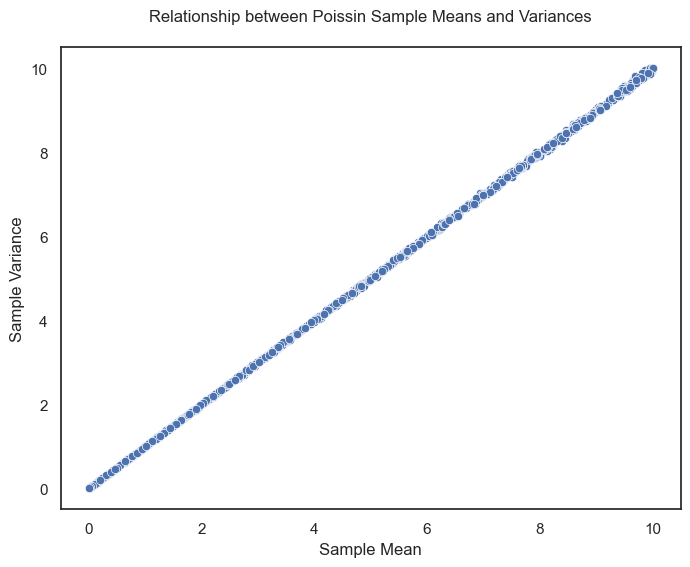

In [12]:
# Step 1: Generate 1000 random samples from Poisson distribution
sample_size = 1000
lambdas = np.random.uniform(low=0, high=10, size=sample_size)

# Step 2: Compute the mean and variance of each sample
sample_means = np.zeros(sample_size)
sample_variances = np.zeros(sample_size)

for i in range(lambdas.size):
    sample = np.random.poisson(lambdas[i], size=100000)
    sample_means[i] = np.mean(sample)
    sample_variances[i] = np.var(sample)

# Step 3: Visualize the relationship between sample means and variances
sns.scatterplot(x=sample_means, y=sample_variances)
plt.xlabel('Sample Mean')
plt.ylabel('Sample Variance')
plt.title('Relationship between Poissin Sample Means and Variances\n')
plt.show()

### Cross-Validation across $\alpha$

We have set the value of $\alpha$, the L2 penalty strength, to zero. Now we want to use cross-validation in order to determine the best value of $\alpha$ for the problem at hand.

For the PoissonRegressor in scikit-learn, the default scoring metric is the [mean Poisson deviance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_poisson_deviance.html), which is a measure of how well the model fits the data based on the Poisson distribution. The lower the mean Poisson deviance, the better the model fits the data.

In [13]:
# X, y
X = data_set.drop('num_awards', axis=1)
y = data_set['num_awards']

# Create a pipeline for preprocessing and Poisson Regression
pipeline = Pipeline([
    ('regressor', PoissonRegressor(max_iter=10000))
])

# Define the parameter grid for tuning
param_grid = {
    'regressor__alpha': [0, .01 , .1, .25, .5, .75, 1, 2, 5, 10, 20, 50, 100] 
}

# Create a cross-validation strategy
cv = KFold(n_splits=5)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           cv=cv)
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'regressor__alpha': 0.01}
Best Score:  0.05972784891778191


We will now re-train the optimal model on the whole data set.

In [14]:
# optimal alpha
l2_penalty = grid_search.best_params_['regressor__alpha']

# Create a pipeline for preprocessing and Poisson Regression
pipeline = Pipeline([
    ('regressor', PoissonRegressor(alpha=l2_penalty, max_iter=10000))
])

# Fit L2 regularized Poisson regression model
pipeline.fit(X, y)

# Grab model
optimal_model = pipeline.named_steps['regressor']

# Print the exp(coefficients)
coefficients = optimal_model.coef_
exp_coefficients = np.exp(optimal_model.coef_)
intercept = optimal_model.intercept_
exp_intercept = np.exp(optimal_model.intercept_)
print("Intercept:", intercept)
print("Coefficients:", coefficients)
print("exp(Intercept):", exp_intercept)
print("exp(Coefficients):", exp_coefficients)

# How good is the model?
d2 = optimal_model.score(X,y)
print("D2 = ", d2)

Intercept: -5.1298895279103895
Coefficients: [0.07170807 0.85390973 0.1459363 ]
exp(Intercept): 0.005917214124585116
exp(Coefficients): [1.07434167 2.34881214 1.15712248]
D2 =  0.3398938334424878


$D^2$ is defined as 

$$D^2=1-\frac{D(y_{true}, y_{pred})}{D_null}$$

$D_{null}$ is the null deviance, i.e. the deviance of a model with intercept alone, which corresponds to $y_{pred}=\bar{y}$.

Best possible score is 1.0 and it can be negative.

For a fitted Poisson regression the deviance is equal to

$$D = 2 \sum^{n}_{i=1} \{ Y_{i} \log(Y_{i}/\mu_{i}) - (Y_{i}-\mu_{i}) \}$$

where $\mu_{i}$ is the predicted expected counts, and where if $Y_i=0$, the $Y_{i} \log(Y_{i}/\mu_{i})$ term is taken to be zero, and

$$\mu_{i} = \exp(\hat{\beta}_{0} + \hat{\beta}_{1}X_{1} + ... + \hat{\beta}_{p} X_{p})$$

The deviance is a measure of the discrepancy between the observed counts ($y_{\text{true}}$) and the predicted values ($\hat{y}_{\text{pred}}$) from the Poisson regression model. It quantifies how well the model predicts the observed data. A lower deviance value indicates a better fit to the data.

In [15]:
def calculate_dev(y_true,y_pred):
    if y_pred.size > 1:
        score = np.zeros(y_true.size)
        y0 = np.where(y_true==0)[0]
        yn0 = np.where(y_true!=0)[0]
        score[y0] = 2*(0 - (y_true[y0]-y_pred[y0]))
        score[yn0] = 2*(y_true[yn0] * np.log(y_true[yn0]/y_pred[yn0]) - (y_true[yn0]-y_pred[yn0]))
        return(score.sum())
    else:
        score = np.zeros(y_true.size)
        y0 = np.where(y_true==0)[0]
        yn0 = np.where(y_true!=0)[0]
        score[y0] = 2*(0 - (y_true[y0]-y_pred))
        score[yn0] = 2*(y_true[yn0] * np.log(y_true[yn0]/y_pred) - (y_true[yn0]-y_pred))
        return(score.sum())

res_deviance = calculate_dev(y, optimal_model.predict(X))
null_deviance = calculate_dev(y, np.mean(y))
print(f'Residual Deviance: {res_deviance}')
print(f'Null Deviance: {null_deviance}')
d2 = 1-(res_deviance/null_deviance)
print(f'D2: {d2}')

Residual Deviance: 189.89421590971443
Null Deviance: 287.67223445286476
D2: 0.3398938334424878


Overdispersion?

In [16]:
num_params = optimal_model.coef_.size + 1
ddof = y.size - num_params
print(f'Residual Degrees of freedom: {ddof}')
print(f'Residual Deviance: {res_deviance}')
res_deviance/ddof

Residual Degrees of freedom: 196
Residual Deviance: 189.89421590971443


0.9688480403556858

### Model predictions

In scikit-learn's `PoissonRegressor`, the predicted values obtained from `model.predict(X)` are already on the scale of the expected counts ($\lambda$) rather than the logarithm of the expected counts. 

In [17]:
preds = optimal_model.predict(X)

predictions = pd.DataFrame({'observed': y, 
                            'predicted': preds})
predictions

,observed,predicted
0,0,0.129520
1,0,0.111933
2,0,0.160606
3,0,0.139148
4,0,0.120557
...,...,...
195,2,2.259838
196,2,1.483126
197,1,2.259838
198,0,2.427839


## 2. Zero-inflated regression

[statsmodels.discrete.count_model.ZeroInflatedPoisson](https://www.statsmodels.org/dev/generated/statsmodels.discrete.count_model.ZeroInflatedPoisson.html)

Zero-inflated regression is a type of regression analysis that addresses the issue of excessive zeros in count data. It is specifically designed for situations where the count data contains an excess of zero values that cannot be adequately explained by a standard count regression model, such as Poisson or Negative Binomial regression.

In many real-world datasets, count data often exhibit an overabundance of zero values that cannot be explained solely by the underlying count process. This excess of zeros can be attributed to two distinct processes:

Structural Zeros: These zeros represent the absence of an event or outcome that could potentially occur. For example, in a study on the number of hospital visits, individuals who have not visited the hospital would contribute structural zeros.

Sampling Zeros: These zeros arise due to the specific sampling process used to collect the data. They are not inherent to the phenomenon being studied but rather occur by chance. For instance, in a study on the number of defects in manufactured products, a sampling zero might represent a product with zero defects due to random chance.

Zero-inflated regression models address these two processes separately by considering a mixture of two components within the model:

- Binary Component: This component models the probability of excess zeros occurring. It is typically modeled using a logistic regression model or a related approach. The binary component estimates the probability of the structural zeros, i.e., the probability that a count observation is exactly zero.

- Count Component: This component models the count values that are greater than zero. It is typically modeled using a count regression model (e.g., Poisson or Negative Binomial regression) applied to the non-zero part of the data.

By incorporating both the binary and count components, zero-inflated regression models provide a more comprehensive approach to capture the excess zeros in the count data. These models estimate the probability of structural zeros and provide estimates for the count component that consider only the non-zero observations. This allows for a more accurate analysis and prediction of count data with excessive zeros.

In [18]:
X

,math,prog_2,prog_3
0,41,0,1
1,41,0,0
2,44,0,1
3,42,0,1
4,40,0,1
...,...,...,...
195,71,1,0
196,75,0,1
197,71,1,0
198,72,1,0


In [19]:
y

0      0
1      0
2      0
3      0
4      0
      ..
195    2
196    2
197    1
198    0
199    3
Name: num_awards, Length: 200, dtype: int64

In [20]:
y.value_counts()

0    124
1     49
2     13
3      9
5      2
4      2
6      1
Name: num_awards, dtype: int64

In [21]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson

# add constant to X
X1 = sm.add_constant(X)

# Fit the zero-inflated Poisson regression model
zi_model = ZeroInflatedPoisson(endog=y, exog=X1)
res = zi_model.fit()

# Print the model summary
print(res.summary())

         Current function value: 0.912897
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:              num_awards   No. Observations:                  200
Model:             ZeroInflatedPoisson   Df Residuals:                      196
Method:                            MLE   Df Model:                            3
Date:                 Sat, 13 May 2023   Pseudo R-squ.:                  0.1749
Time:                         03:25:09   Log-Likelihood:                -182.58
converged:                       False   LL-Null:                       -221.28
Covariance Type:             nonrobust   LLR p-value:                 1.103e-16
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -3.0012      1.383     -2.171      0.030     

/Users/goransm/Work/___DataKolektiv/_EDU/DSS_Vol00_PythonDS_2023/dss00python2023/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/goransm/Work/___DataKolektiv/_EDU/DSS_Vol00_PythonDS_2023/dss00python2023/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
res.params

inflate_const   -3.001218
const           -5.192212
math             0.070012
prog_2           1.085964
prog_3           0.369015
dtype: float64

AIC

In [23]:
# AIC = -2 * LL + 2 * k
ll = res.llf
k = X1.shape[1]
aic = -2*ll + 2*k
print(f'AIC: {aic}')

AIC: 373.15889296016417


## 3. Negative Binomial Regression

[statsmodels.discrete.discrete_model.NegativeBinomial](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.NegativeBinomial.html)

Negative Binomial Regression is a statistical regression technique used to model count data with overdispersion, where the variance of the data exceeds the mean. It is an extension of the Poisson regression model, which assumes that the mean and variance of the count data are equal.

Overdispersion: The Negative Binomial Regression accounts for overdispersion by allowing the variance to be larger than the mean, unlike the Poisson regression model. Overdispersion occurs when there is more variability in the data than can be explained by a Poisson distribution.

Regression Model: Negative Binomial Regression extends the Poisson regression by introducing an additional parameter called the dispersion parameter, $\alpha$. This parameter captures the extra variation in the data beyond what is predicted by the mean.

Interpretation of Coefficients: The coefficients in Negative Binomial Regression represent the change in the expected count for a one-unit change in the corresponding predictor variable, holding other variables constant. They can be interpreted similarly to coefficients in Poisson regression.

In [24]:
from statsmodels.discrete.discrete_model import NegativeBinomial

# Add constant column to X for intercept term
X1 = sm.add_constant(X)

# Fit the negative binomial regression model
model = NegativeBinomial(endog=y, exog=X1)
res = model.fit()

# Print the model summary
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.909527
         Iterations: 30
         Function evaluations: 35
         Gradient evaluations: 35
                     NegativeBinomial Regression Results                      
Dep. Variable:             num_awards   No. Observations:                  200
Model:               NegativeBinomial   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Sat, 13 May 2023   Pseudo R-squ.:                  0.1632
Time:                        03:25:09   Log-Likelihood:                -181.91
converged:                       True   LL-Null:                       -217.37
Covariance Type:            nonrobust   LLR p-value:                 2.696e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2933      0.709     -

AIC

In [25]:
# AIC = -2 * LL + 2 * k
ll = res.llf
k = X1.shape[1]
aic = -2*ll + 2*k
print(f'AIC: {aic}')

AIC: 371.8108937266304


In `statsmodels`' Negative Binomial regression, the heterogeneity parameter $\alpha$ represents the dispersion parameter of the negative binomial distribution. It quantifies the level of overdispersion or underdispersion in the data.

The dispersion parameter $\alpha$ is estimated during the fitting process of the negative binomial regression model. It reflects the extent to which the observed variance of the dependent variable deviates from the mean, considering the count distribution assumption.

The interpretation of the $\alpha$ value in negative binomial regression is as follows:

- $\alpha$ = 0: This corresponds to the special case of a Poisson distribution, where the variance is equal to the mean. In this scenario, there is no dispersion present, and the negative binomial regression model reduces to a Poisson regression model.

- $\alpha$ > 0: When alpha is greater than zero, it indicates overdispersion. This means that the observed variance is higher than what would be expected under a Poisson distribution assumption. A larger alpha value suggests a higher degree of overdispersion.

- $\alpha$ < 0: In rare cases, a negative alpha value can occur, indicating underdispersion. This implies that the observed variance is lower than expected under a Poisson distribution assumption. However, negative alpha values are not commonly encountered in practice.

It's worth noting that the alpha value obtained from the negative binomial regression is on the log scale. If you wish to interpret it directly, you can exponentiate the value to obtain the dispersion parameter.

In summary, the alpha parameter in statsmodels' negative binomial regression represents the dispersion parameter of the negative binomial distribution. A higher alpha value indicates greater overdispersion in the data, while a lower alpha value suggests less overdispersion or even underdispersion.

In [26]:
res.params

const    -5.293314
math      0.071069
prog_2    1.075071
prog_3    0.366960
alpha     0.163541
dtype: float64

#### Example

In [27]:
data_set = pd.read_csv(os.path.join(data_dir, "nb_data.csv"))
data_set.drop('id', axis=1, inplace=True)
data_set

,gender,math,daysabs,prog
0,male,63,4,2
1,male,27,4,2
2,female,20,2,2
3,female,16,3,2
4,female,2,3,2
...,...,...,...,...
309,male,26,1,2
310,female,79,3,3
311,female,59,0,2
312,female,90,0,3


In [28]:
data_set = pd.get_dummies(data_set, columns=['prog', 'gender'], drop_first=True)
data_set

,math,daysabs,prog_2,prog_3,gender_male
0,63,4,1,0,1
1,27,4,1,0,1
2,20,2,1,0,0
3,16,3,1,0,0
4,2,3,1,0,0
...,...,...,...,...,...
309,26,1,1,0,1
310,79,3,0,1,0
311,59,0,1,0,0
312,90,0,0,1,0


`X`, `y`

In [29]:
X = data_set.drop('daysabs', axis=1)
y = data_set['daysabs']

#### Poisson

In [30]:
# Add a constant to the independent variable matrix
X1 = sm.add_constant(X)

# Fit a Poisson regression model
poisson_model = sm.GLM(y, X1, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print(poisson_results.summary())

# To test for overdispersion, we calculate the ratio of the deviance to the degrees of freedom
# If this ratio is significantly greater than 1, it indicates overdispersion
ratio = poisson_results.deviance / poisson_results.df_resid
print('Ratio of Deviance to Degrees of Freedom: ', ratio)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                daysabs   No. Observations:                  314
Model:                            GLM   Df Residuals:                      309
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1315.1
Date:                Sat, 13 May 2023   Deviance:                       1746.8
Time:                        03:25:09   Pearson chi2:                 2.01e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7768
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.7595      0.064     43.270      

AIC

In [31]:
# AIC = -2 * LL + 2 * k
ll = poisson_results.llf
k = X1.shape[1]
aic = -2*ll + 2*k
print(f'AIC: {aic}')

AIC: 2640.1776172636164


#### Negative Binomial

In [32]:
# Add constant column to X for intercept term
X1 = sm.add_constant(X)

# Fit the negative binomial regression model
model = NegativeBinomial(endog=y, exog=X1)
results_nb = model.fit()

# Print the model summary
print(results_nb.summary())

Optimization terminated successfully.
         Current function value: 2.752081
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
                     NegativeBinomial Regression Results                      
Dep. Variable:                daysabs   No. Observations:                  314
Model:               NegativeBinomial   Df Residuals:                      309
Method:                           MLE   Df Model:                            4
Date:                Sat, 13 May 2023   Pseudo R-squ.:                 0.03605
Time:                        03:25:09   Log-Likelihood:                -864.15
converged:                       True   LL-Null:                       -896.47
Covariance Type:            nonrobust   LLR p-value:                 3.068e-13
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.7075      0.203   

AIC

In [33]:
# AIC = -2 * LL + 2 * k
ll = results_nb.llf
k = X1.shape[1]
aic = -2*ll + 2*k
print(f'AIC: {aic}')

AIC: 1738.3070963921077


### Further Reading

- [Regression with Count Data: Poisson and Negative Binomial, Matthew E. Clapham](https://www.youtube.com/watch?v=uGKnoAw-PFQ)
- [An Introduction to the Poisson Regression Model, Morten Nyboe Tabor](https://www.youtube.com/watch?v=U-bMvccsn08)
- [Introduction to Poisson regression models for count data, Gabriele Durrant, NCRM](https://www.ncrm.ac.uk/resources/online/all/?id=20429)
- [Poisson regression, English Wikipedia](https://en.wikipedia.org/wiki/Poisson_regression)

***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>